# Demo: sequences <-> embeddings
The following notebook provides a demonstration how the ts2e library can be used to convert time series into embeddings. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN). All the column descriptions are provided. Currency is USD.

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import seaborn as sns
import networkx as nx
import pandas as pd
from timeseries.strategies import TimeseriesToGraphStrategy, TimeseriesEdgeVisibilityConstraintsNatural, EdgeWeightingStrategyNull
from timeseries.vectors import TimeSeriesEmbedding
from sklearn.preprocessing import MinMaxScaler
from core import model 

## Loading data

We first load the dataset :)

In [4]:
amazon_data = pd.read_csv(os.path.join(os.getcwd(), "amazon", "AMZN.csv"))

To properly use the ‘Date’ column, we convert it to datetime format and ensure the dates are recognized as date objects. We then set the ‘Date’ column as the index of the DataFrame. This creates a time-series structure, facilitating analysis and visualization over time.

In [5]:
amazon_data["Date"] = pd.to_datetime(amazon_data["Date"])
amazon_data.set_index("Date", inplace=True)

# How does the time series look like?

In [6]:
def plot_timeseries(sequence, title, x_legend, y_legend, color):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

In [7]:
def plot_timeseries_sequence(df_column, title, x_legend, y_legend, color='black'):
    sequence = model.Timeseries(model.TimeseriesArrayStream(df_column)).to_sequence()
    plot_timeseries(sequence, title, x_legend, y_legend, color)

In [8]:
def sequence_to_graph(column, color):
    strategy = TimeseriesToGraphStrategy(
        visibility_constraints=[TimeseriesEdgeVisibilityConstraintsNatural()],
        graph_type="undirected",
        edge_weighting_strategy=EdgeWeightingStrategyNull(),
    )

    g = strategy.to_graph(model.TimeseriesArrayStream(column))
    pos=nx.spring_layout(g.graph, seed=1)
    nx.draw(g.graph, pos, node_size=40, node_color=color)

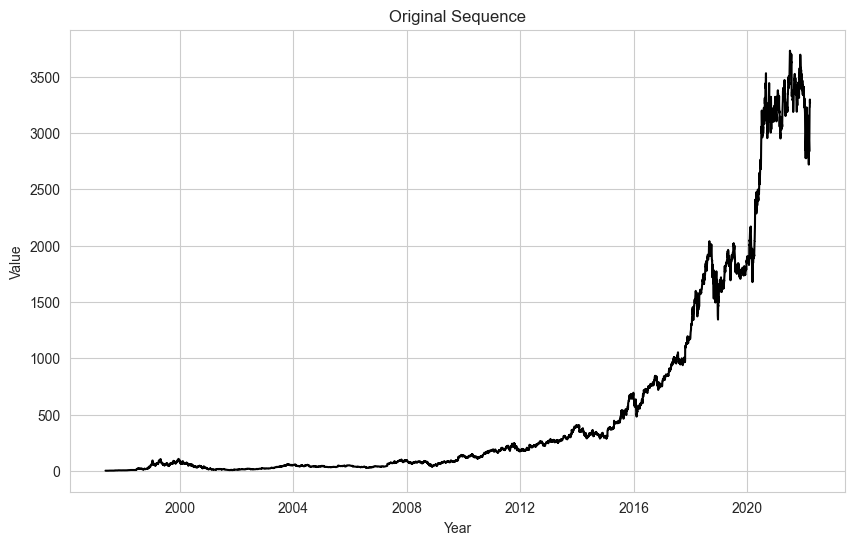

In [9]:
plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")

Given the great length of the timeseries, let's focus on some sub-segments, so that we can better appreciate its behavior.

In [10]:
segment_1 = amazon_data[60:260]
segment_2 = amazon_data[960:1160]
segment_3 = amazon_data[3120:3320]
segment_4 = amazon_data[4320:4520]
segment_5 = amazon_data[5640:5840]
segment_6 = amazon_data[6000:6200]

How do the plots and networks (graphs) for these segments look like?

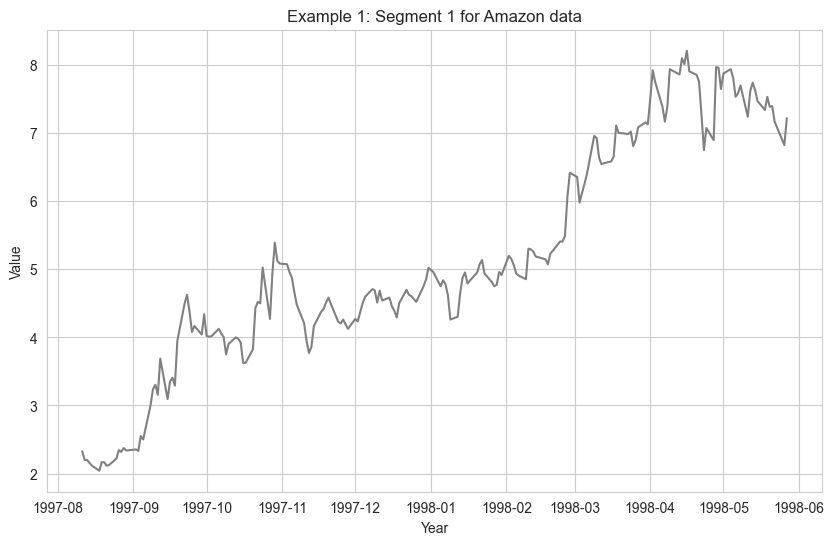

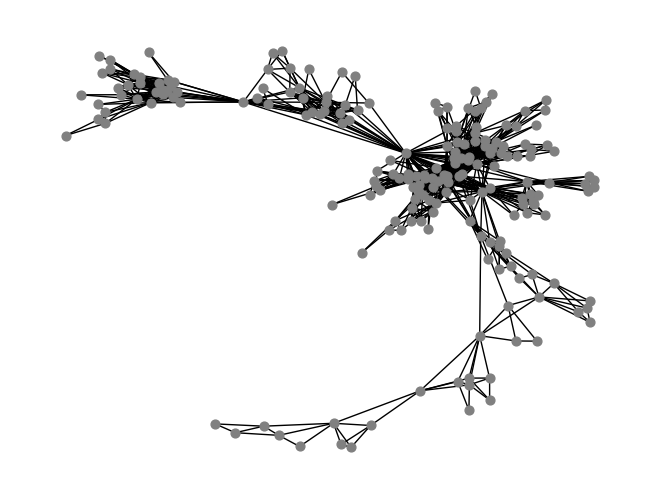

In [15]:
plot_timeseries_sequence(segment_1["Close"], "Example 1: Segment 1 for Amazon data", "Year", "Value", 'gray')
sequence_to_graph(segment_1["Close"], 'gray')

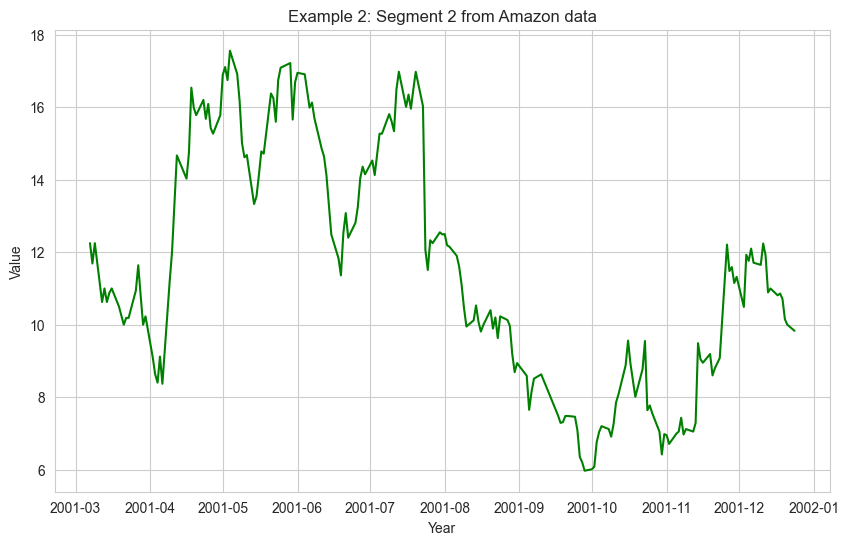

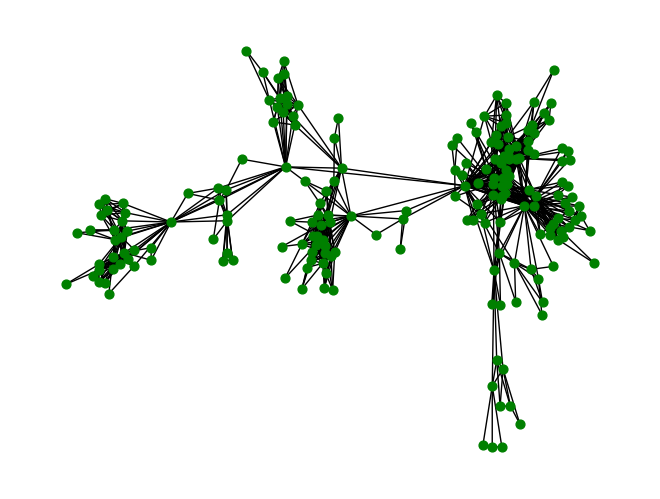

In [17]:
plot_timeseries_sequence(segment_2["Close"], "Example 2: Segment 2 from Amazon data", "Year", "Value", 'green')
sequence_to_graph(segment_2["Close"], 'green')

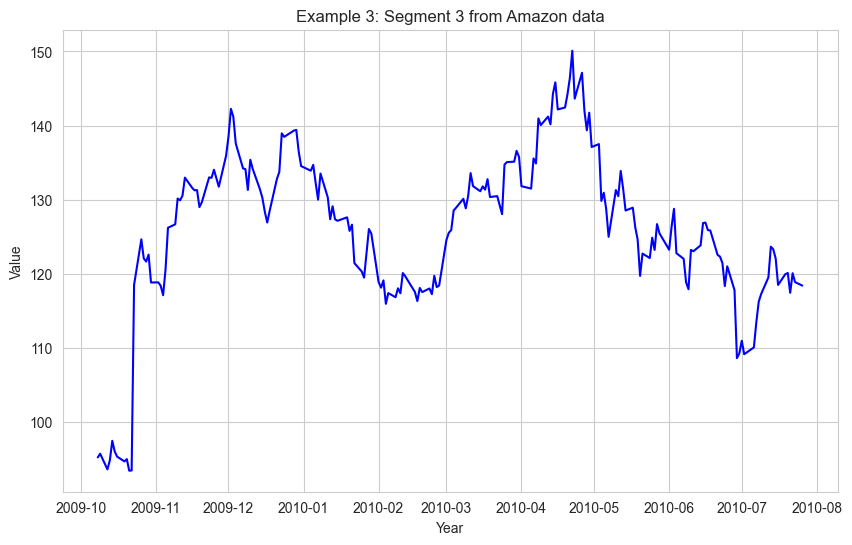

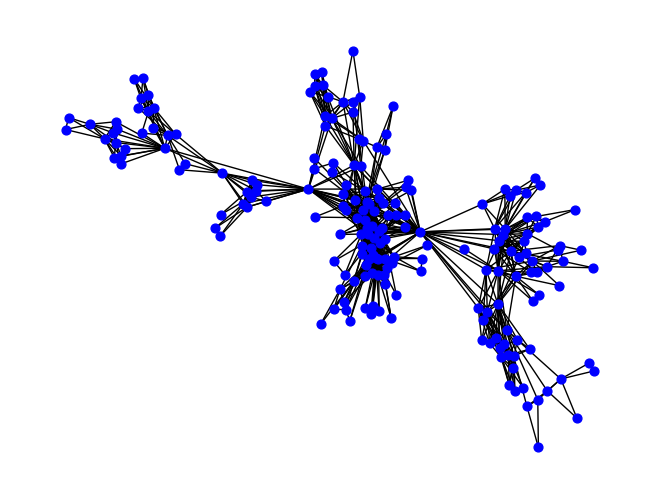

In [18]:
plot_timeseries_sequence(segment_3["Close"], "Example 3: Segment 3 from Amazon data", "Year", "Value", 'blue')
sequence_to_graph(segment_3["Close"], 'blue')

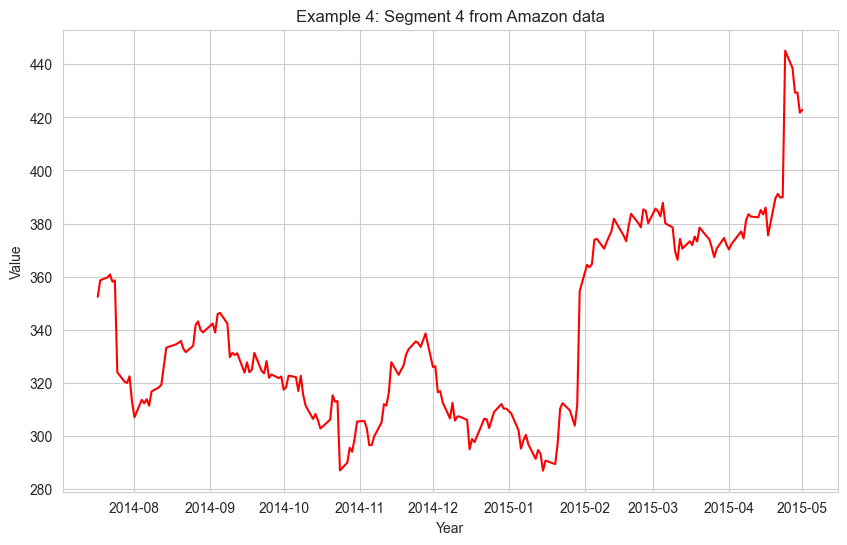

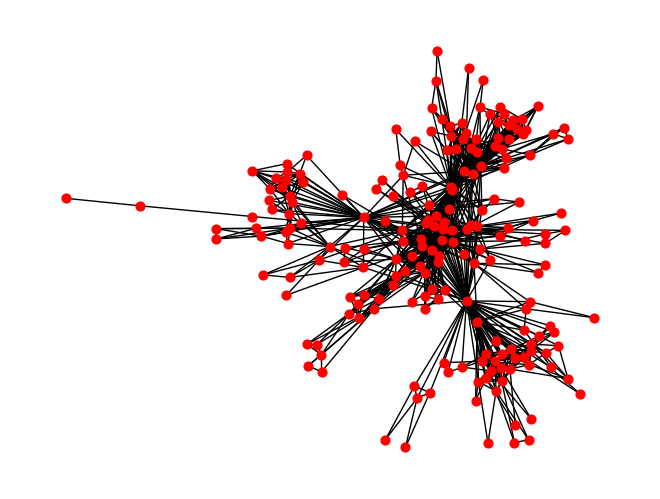

In [19]:
plot_timeseries_sequence(segment_4["Close"], "Example 4: Segment 4 from Amazon data", "Year", "Value", 'red')
sequence_to_graph(segment_4["Close"], 'red')

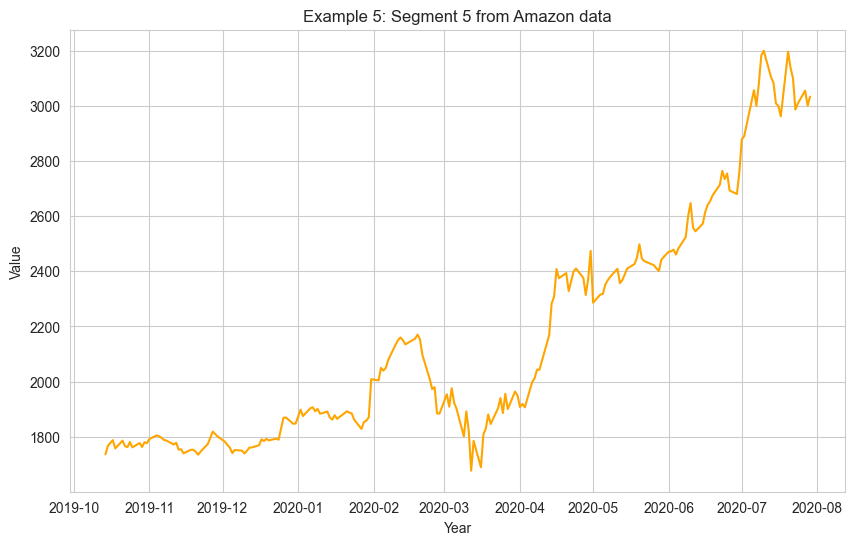

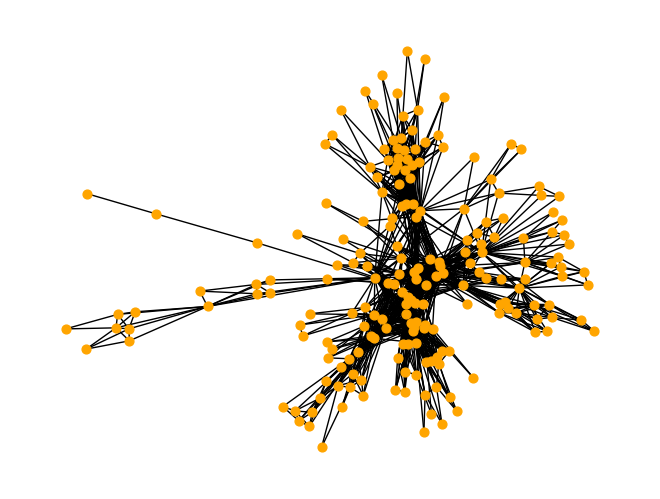

In [20]:
plot_timeseries_sequence(segment_5["Close"], "Example 5: Segment 5 from Amazon data", "Year", "Value", 'orange')
sequence_to_graph(segment_5["Close"], 'orange')

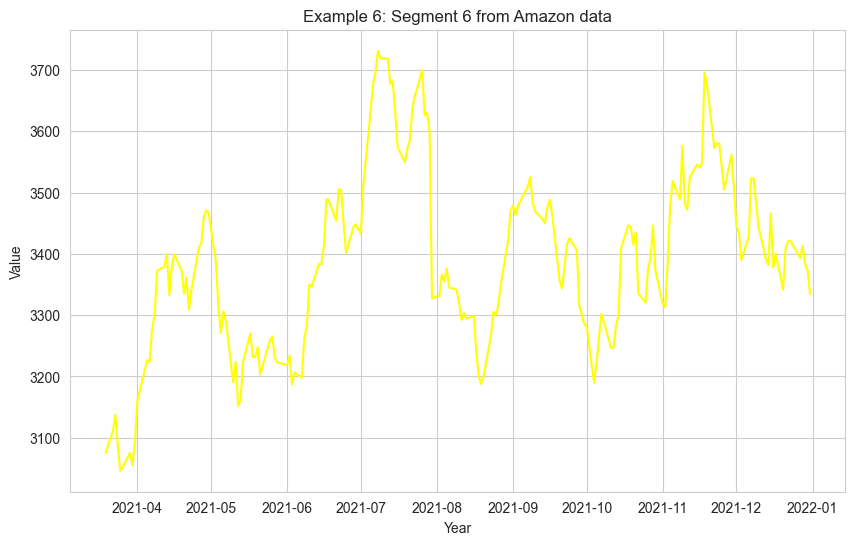

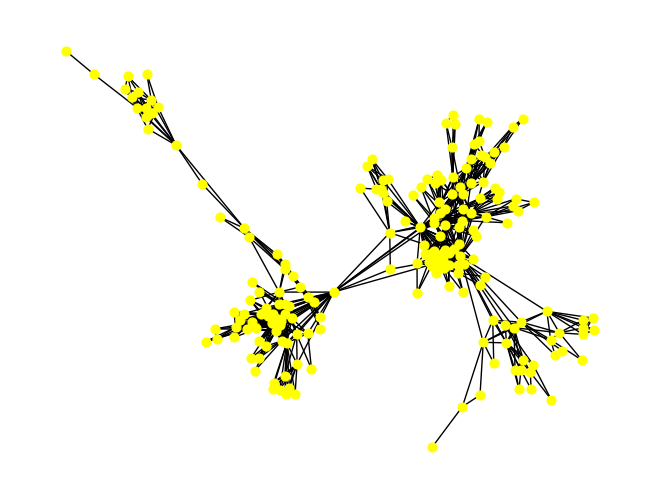

In [21]:
plot_timeseries_sequence(segment_6["Close"], "Example 6: Segment 6 from Amazon data", "Year", "Value", 'yellow')
sequence_to_graph(segment_6["Close"], 'yellow')

Let's turn the timeseries into vectors!

In [22]:
def normalize_data(dataset,column):
    data = dataset[column].values
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, 1)).flatten()    

This function normalizes a specific column of a dataset using the Min-Max scaling technique. Normalization is a common preprocessing step in machine learning, ensuring that all features have the same scale. It helps algorithms converge faster and perform better.

In [23]:
def create_and_train_ts_embedding (data, window_size=100, epochs=20):
    ts_embedding = TimeSeriesEmbedding(data, window_size)
    print(ts_embedding)
    print(ts_embedding.data.size)
    ts_embedding.train_lstm(epochs)
    print(ts_embedding)
    return ts_embedding

Here, a method called TimeSeriesEmbedding is employed to generate embeddings for time series data. Embeddings serve as compact representations of data in a lower-dimensional space, effectively capturing significant patterns and relationships. The function utilizes a window-based strategy to derive embeddings from the time series data. Furthermore, it includes the training of a Long Short-Term Memory (LSTM) neural network model. This model is trained to discern intricate embeddings directly from the data, enhancing comprehension of temporal dynamics and facilitating subsequent analyses.

In [24]:
def print_ts_embeddings_info(ts_embedding):
    embeddings = ts_embedding.get_embeddings()
    print("Shape of embeddings:", embeddings.shape)
    print("Sample embeddings:\n", embeddings[:5])
    return embeddings

This function retrieves and presents information regarding the embeddings produced by the TimeSeriesEmbedding model. It offers insights into the shape of the embeddings and presents a glimpse of the embeddings themselves, facilitating further analysis and interpretation.

In [111]:
def calculate_embeddings_similarity(ts_embedding, similarity_threshold=0.9):
    embeddings = ts_embedding.get_embeddings()
    num_embeddings = embeddings.shape[0]
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    similar_pairs = []
    
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):  # Avoid duplicate calculations
            cosine_sim = 1 - cosine(embeddings[i], embeddings[j])
            similarity_matrix[i, j] = cosine_sim
            similarity_matrix[j, i] = cosine_sim 
            
            # closer to 1, more similar
            if cosine_sim > similarity_threshold:
                similar_pairs.append((i, j, cosine_sim))
    
    print("Pairwise cosine similarity:\n", similarity_matrix)
    print("Similar pairs (above threshold):\n", similar_pairs)
    return similarity_matrix, similar_pairs

With this function we calculate the cosine similarity between pairs of embeddings from a provided tensor and identifies those pairs that exceed a specified similarity threshold. It retrieves the embeddings, initializes a similarity matrix and a list for similar pairs, and then computes the pairwise cosine similarities, storing the results in the matrix while recording pairs with similarities above the threshold. The similarity matrix and the list of similar pairs, including their similarity scores, are printed and returned. This process helps to identify and quantify the similarity between different embeddings efficiently.

In [112]:
def sort_similarity_matrix(similarity_matrix):
    num_embeddings = similarity_matrix.shape[0]
    
    # Sort similarity matrix by cosine distance increasing
    sorted_indices = np.argsort(-similarity_matrix, axis=None)
    sorted_similarity_matrix = similarity_matrix.flatten()[sorted_indices].reshape(similarity_matrix.shape)
    
    # Collect sorted pairs
    sorted_pairs = []
    for index in sorted_indices:
        i, j = divmod(index, num_embeddings)
        if i < j: 
            sorted_pairs.append((i, j, similarity_matrix[i, j]))

    print("Pairwise cosine similarity (sorted):\n", sorted_similarity_matrix)
    print("Sorted pairs:\n", sorted_pairs)
    return sorted_similarity_matrix, sorted_pairs

We aim to sort the similarity matrix by decreasing cosine distance to identify the most similar pairs. This function gathers sorted pairs of indices, focusing solely on the upper triangular portion to eliminate duplicate pairs.

In [113]:
def plot_similarity_heatmap(similarity_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='gray_r')
    plt.title("Heatmap of Pairwise Cosine Similarity")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Index")
    plt.show()

The provided similarity matrix is plotted using a color map ('gray') to represent the cosine similarity. The resulting heatmap provides a visual representation of similarity relationships between embeddings, with warmer colors indicating higher similarity and cooler colors indicating lower similarity. This visualization aids in understanding the clustering and relationships within the embeddings, facilitating further analysis and interpretation.

#### Example 1: Segment 1 from Amazon data

In [114]:
data_1 = normalize_data(segment_1,'Close')
ts_embedding_1 = create_and_train_ts_embedding (data_1)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6294Epoch 1, Loss: 0.5900265574455261
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.6136
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2930Epoch 2, Loss: 0.27266186475753784
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2849
Epoch 3/20
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0841Epoch 3, Loss: 0.05567074194550514
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0675
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0236Epoch 4, Loss: 0.0368831530213356
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0289
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0536Epoch 5, Loss: 0.0418815091252327
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0489
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0073Epoch 6, Loss: 0.006222246680408716
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0069
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0113Epoch 7, Loss: 0.011958236806094646
4/4 ━━━━

In [115]:
embeddings_1 = print_ts_embeddings_info (ts_embedding_1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-4.38581482e-02  5.86141832e-02 -6.89198151e-02  8.46641362e-02
   1.52441906e-02  1.30838901e-01  1.59688927e-02  7.47897103e-03
   1.58957914e-01  1.18168304e-02  2.29360573e-02 -1.55375257e-01
   5.60888126e-02  9.19320956e-02  1.96265755e-03  1.26196966e-02
  -2.04085163e-03  3.71249542e-02 -3.14711616e-03 -1.23301387e-01
  -5.79705084e-05  6.09786659e-02 -1.42532721e-04 -1.00446157e-01
  -6.31758850e-03  9.60524566e-03 -3.54372375e-02  1.39001369e-01
  -1.02002762e-01 -3.15089896e-02  1.91722102e-02 -1.19024262e-01
  -2.79053859e-02 -1.32142203e-02  9.78758484e-02  3.40263657e-02
  -9.51363519e-03 -1.17122065e-02 -5.91866076e-02 -3.56978038e-03
   4.12404239e-02  9.93403345e-02  4.51430976e-02  6.63751736e-02
   7.51364231e-02  3.77854370e-02  3.09572518e-02  1.30405247e-01
  -2.59300997e-03  1.09154284e-02]
 [-4.42338549e-02  5.94351627e-02 -6.98274001e-02  8.62663835e-02
   1.56709682e-02 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Pairwise cosine similarity:
 [[0.         0.9999839  0.99996895 ... 0.99693296 0.9971754  0.99756097]
 [0.9999839  0.         0.99996348 ... 0.99727474 0.99749217 0.99782795]
 [0.99996895 0.99996348 0.         ... 0.99705924 0.99731865 0.99773794]
 ...
 [0.99693296 0.99727474 0.99705924 ... 0.         0.99998418 0.99985988]
 [0.9971754  0.99749217 0.99731865 ... 0.99998418 0.         0.99993826]
 [0.99756097 0.99782795 0.99773794 ... 0.99985988 0.99993826 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9999838968256379), (0, 2, 0.9999689526458407), (0, 3, 0.9999511972504833), (0, 4, 0.999909229639685), (0, 5, 0.9997392960665903), (0, 6, 0.9989752831612675), (0, 7, 0.9983151226132917), (0, 8, 0.9987576644426405), (0, 9, 0.9994289365868408), (0, 10, 0.9997963204123034), (0, 11, 0.9998267102288358), (0, 12, 0.9999367521213469), (0, 13, 0.9999853707692449), (0, 14, 0.9999484009064682), (0, 15, 0.9999503209173017), (0, 16, 0.9999151298429665), 

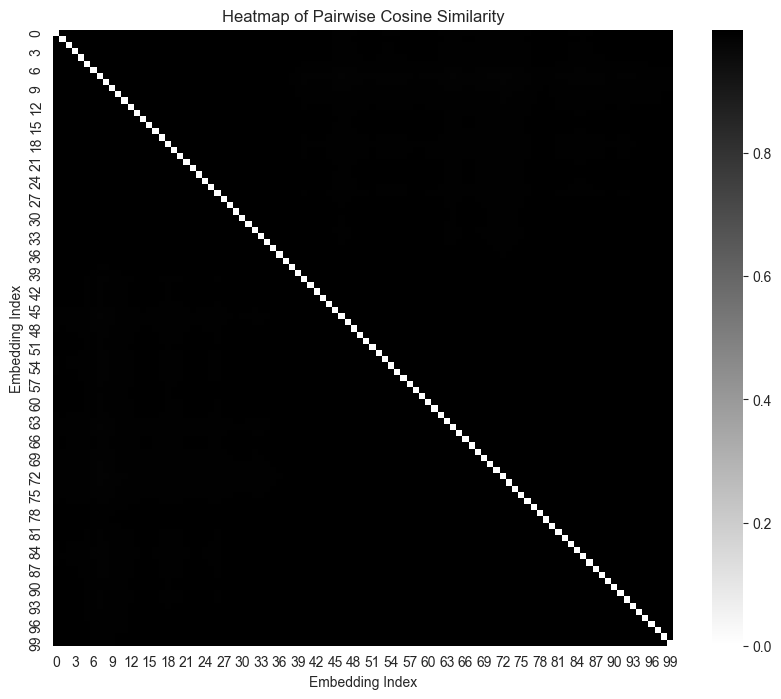

In [116]:
similarity_matrix_1, similar_pairs_1 = calculate_embeddings_similarity(ts_embedding_1)
plot_similarity_heatmap(similarity_matrix_1)

In [117]:
sorted_matrix_1, sorted_pairs_1 = sort_similarity_matrix(similarity_matrix_1)

Pairwise cosine similarity (sorted):
 [[0.9999996  0.9999996  0.99999958 ... 0.99999335 0.99999325 0.99999325]
 [0.99999312 0.99999312 0.99999308 ... 0.9999863  0.99998589 0.99998589]
 [0.99998583 0.99998583 0.99998565 ... 0.99997914 0.99997896 0.99997896]
 ...
 [0.99188695 0.99188695 0.99182688 ... 0.99089291 0.99084401 0.99084401]
 [0.99080285 0.99080285 0.99080141 ... 0.98781692 0.98720386 0.98720386]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(91, 92, 0.9999995992630927), (60, 61, 0.9999995841133539), (87, 88, 0.9999995776706916), (96, 97, 0.999999357654532), (53, 54, 0.9999993013578719), (19, 20, 0.9999992415961874), (31, 34, 0.9999984534177215), (55, 56, 0.9999983209712864), (90, 93, 0.9999982420454473), (94, 96, 0.9999981301106676), (84, 85, 0.9999979940557873), (94, 95, 0.9999977023923432), (52, 53, 0.9999975904842527), (70, 71, 0.9999975633127987), (54, 55, 0.9999974029771839), (22, 23, 0.9999973924916332), (95, 96, 0.999997033257

<a id = 'example_1_heatmap'></a>

#### Example 2: Segment 2 from Amazon data

In [118]:
data_2 = normalize_data(segment_2,'Close')
ts_embedding_2 = create_and_train_ts_embedding (data_2)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1079Epoch 1, Loss: 0.09348349273204803
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1021
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0502Epoch 2, Loss: 0.04079478234052658
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0464
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0142Epoch 3, Loss: 0.013929937966167927
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0141
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0182Epoch 4, Loss: 0.017612239345908165
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0180
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0167Epoch 5, Loss: 0.015828482806682587
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0164
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0104Epoch 6, Loss: 0.010388119146227837
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0104
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0093Epoch 7, Loss: 0.009506392292678356
4/

In [119]:
embeddings_2 = print_ts_embeddings_info (ts_embedding_2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.07365555 -0.17584822 -0.04310815 -0.09850571 -0.06429432  0.13793972
   0.02239178  0.22074175  0.15208374 -0.14436309 -0.02877939  0.07749258
   0.07409228 -0.08232339 -0.12724562  0.12610054 -0.05109952  0.03831971
  -0.06344259 -0.03954443  0.08187578 -0.0455376   0.05019693  0.0719426
   0.05738769  0.08933087  0.12521704  0.01381548 -0.22539847 -0.00902856
   0.02655699 -0.02788479 -0.14036752 -0.05468574  0.06877293  0.05923768
   0.00175929 -0.04503028  0.11112919 -0.02259248 -0.03739579 -0.05889798
  -0.01381381  0.0559089  -0.01520919 -0.13795047  0.01506169  0.04521399
   0.05548427 -0.05684846]
 [-0.07225826 -0.16731128 -0.04178831 -0.0929699  -0.06164329  0.13089544
   0.01840443  0.2117399   0.14418061 -0.13754897 -0.02689267  0.07449326
   0.07094396 -0.07739875 -0.1225685   0.12236803 -0.04858347  0.03511344
  -0.06066123 -0.03583693  0.07918416 -0.04114444  0.04932358  0.067286

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Pairwise cosine similarity:
 [[0.         0.99987082 0.99957849 ... 0.99762594 0.99819816 0.99811347]
 [0.99987082 0.         0.99990901 ... 0.99758519 0.99827517 0.99833515]
 [0.99957849 0.99990901 0.         ... 0.99761005 0.99829304 0.99838357]
 ...
 [0.99762594 0.99758519 0.99761005 ... 0.         0.99967913 0.99889477]
 [0.99819816 0.99827517 0.99829304 ... 0.99967913 0.         0.99976209]
 [0.99811347 0.99833515 0.99838357 ... 0.99889477 0.99976209 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9998708226456038), (0, 2, 0.999578494665739), (0, 3, 0.9991847549116536), (0, 4, 0.9988566153492161), (0, 5, 0.9985017941662714), (0, 6, 0.9982715643005802), (0, 7, 0.9981753068615833), (0, 8, 0.9981928830613953), (0, 9, 0.9979144717489068), (0, 10, 0.9967165163801279), (0, 11, 0.995634643399865), (0, 12, 0.995597768041431), (0, 13, 0.9950379780912341), (0, 14, 0.9942606470005546), (0, 15, 0.9941211345819791), (0, 16, 0.994608042379736), (0,

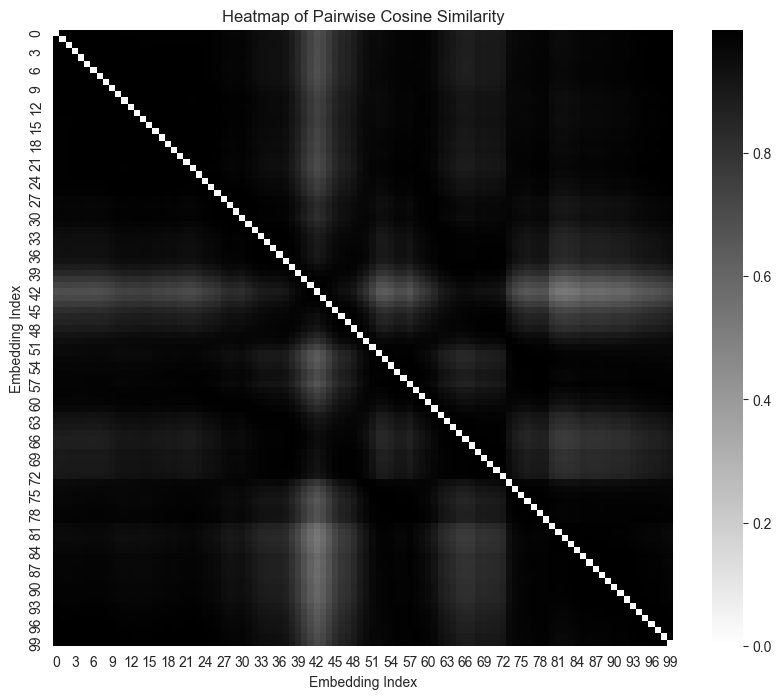

In [120]:
similarity_matrix_2, similar_pairs_2 = calculate_embeddings_similarity(ts_embedding_2)
plot_similarity_heatmap(similarity_matrix_2)

In [121]:
sorted_matrix_2, sorted_pairs_2 = sort_similarity_matrix(similarity_matrix_2)

Pairwise cosine similarity (sorted):
 [[0.99998593 0.99998593 0.99998434 ... 0.99984959 0.9998456  0.9998456 ]
 [0.99984222 0.99984222 0.99984119 ... 0.99957849 0.99957161 0.99957161]
 [0.99956803 0.99956803 0.99956071 ... 0.99926811 0.99926181 0.99926181]
 ...
 [0.69983673 0.69983673 0.69911094 ... 0.6592932  0.65798141 0.65798141]
 [0.65767546 0.65767546 0.65309971 ... 0.54187207 0.53156892 0.53156892]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(6, 7, 0.9999859337010744), (5, 6, 0.9999843402850775), (87, 88, 0.9999820882103035), (16, 17, 0.9999801332724813), (21, 22, 0.9999795806441463), (12, 13, 0.9999775565069149), (90, 91, 0.9999766721434014), (86, 87, 0.999970669870106), (3, 4, 0.9999657084328984), (4, 5, 0.99996319843437), (14, 15, 0.9999603083817602), (13, 14, 0.9999585267469948), (5, 7, 0.9999519850898737), (70, 71, 0.9999497161839142), (91, 92, 0.9999439594109207), (18, 19, 0.9999340256470982), (13, 15, 0.9999337562025576), (90, 

#### Example 3: Segment 3 from Amazon data

In [122]:
data_3 = normalize_data(segment_3,'Close')
ts_embedding_3 = create_and_train_ts_embedding (data_3)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4306Epoch 1, Loss: 0.3941960632801056
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4160
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1979Epoch 2, Loss: 0.17302794754505157
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1880
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0390Epoch 3, Loss: 0.03160381317138672
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0375
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0447Epoch 4, Loss: 0.048185206949710846
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0454
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0350Epoch 5, Loss: 0.03032021038234234
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0341
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112Epoch 6, Loss: 0.012244381941854954
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0116
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0169Epoch 7, Loss: 0.01738189347088337
4/4 ━━

In [123]:
embeddings_3 = print_ts_embeddings_info (ts_embedding_3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.11027483  0.041649    0.00724508 -0.2063433   0.09498993  0.04343309
  -0.06387891 -0.04524095  0.12501736 -0.14010124 -0.03047658 -0.05617027
  -0.04102082 -0.0825764   0.13467997  0.04794658  0.01573269 -0.01159202
   0.0130219   0.01290256 -0.00850226  0.08644293  0.01778022 -0.04311033
   0.0713624   0.01323501 -0.10166816 -0.08901574  0.0201555   0.1301333
   0.00509194 -0.01298417  0.01871178 -0.04197278  0.14184937  0.03917444
   0.06935503 -0.12223487  0.00399447 -0.07140438 -0.0843206   0.07099834
   0.05366526  0.03293924 -0.00903302 -0.01297729 -0.03169099  0.01270315
  -0.01747525 -0.02603698]
 [-0.11325972  0.04532092  0.00906143 -0.2125367   0.09902     0.04789768
  -0.06705508 -0.04920524  0.13160357 -0.14459608 -0.0295954  -0.0595118
  -0.04024327 -0.08579065  0.1388001   0.05178474  0.01811907 -0.01162463
   0.01451511  0.01391187 -0.00703555  0.09039468  0.01993457 -0.0449724

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Pairwise cosine similarity:
 [[0.         0.99980607 0.99950699 ... 0.99877017 0.9988494  0.99852546]
 [0.99980607 0.         0.99992755 ... 0.99773195 0.99783944 0.99739626]
 [0.99950699 0.99992755 0.         ... 0.99702184 0.99714291 0.99663824]
 ...
 [0.99877017 0.99773195 0.99702184 ... 0.         0.99999293 0.99997555]
 [0.9988494  0.99783944 0.99714291 ... 0.99999293 0.         0.99997716]
 [0.99852546 0.99739626 0.99663824 ... 0.99997555 0.99997716 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9998060678530862), (0, 2, 0.9995069853518793), (0, 3, 0.9991478530043584), (0, 4, 0.9991397058207205), (0, 5, 0.9989694895297422), (0, 6, 0.9984970243079593), (0, 7, 0.998538947445909), (0, 8, 0.9986980418767465), (0, 9, 0.9987683540124426), (0, 10, 0.9988861842486476), (0, 11, 0.9988955280464046), (0, 12, 0.9990303624153002), (0, 13, 0.9990801525547622), (0, 14, 0.9990640285010415), (0, 15, 0.9989288735856059), (0, 16, 0.9992327810033269), 

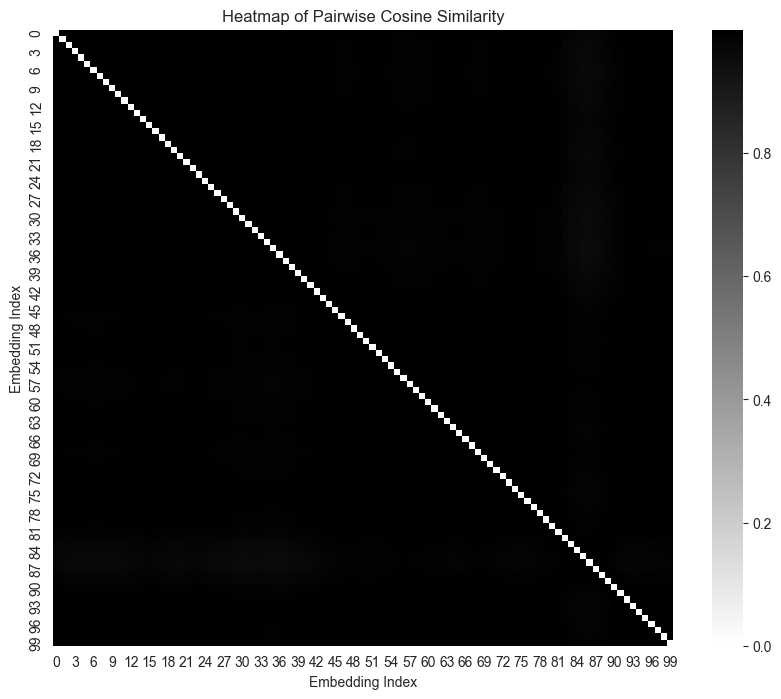

In [124]:
similarity_matrix_3, similar_pairs_3 = calculate_embeddings_similarity(ts_embedding_3)
plot_similarity_heatmap(similarity_matrix_3)

In [125]:
sorted_matrix_3, sorted_pairs_3 = sort_similarity_matrix(similarity_matrix_3)

Pairwise cosine similarity (sorted):
 [[0.99999884 0.99999884 0.9999975  ... 0.99996869 0.99996768 0.99996768]
 [0.99996762 0.99996762 0.99996756 ... 0.99994111 0.99994075 0.99994075]
 [0.99994031 0.99994031 0.99993948 ... 0.99990204 0.9999016  0.9999016 ]
 ...
 [0.97090747 0.97090747 0.97076958 ... 0.96685109 0.96680249 0.96680249]
 [0.96649507 0.96649507 0.96648387 ... 0.95746477 0.95549112 0.95549112]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(23, 24, 0.9999988433044318), (32, 33, 0.9999974969022379), (51, 52, 0.9999974310882186), (19, 20, 0.99999710208175), (10, 11, 0.9999963241672633), (36, 37, 0.9999945685178435), (27, 28, 0.9999944653059406), (97, 98, 0.9999929317623455), (58, 59, 0.9999907402409471), (74, 75, 0.9999905956986985), (79, 80, 0.9999887611273995), (56, 57, 0.9999879520460365), (4, 5, 0.9999878365358232), (61, 62, 0.9999877342022303), (21, 24, 0.9999871293104431), (33, 34, 0.9999858132655348), (34, 36, 0.999985487345061

#### Example 4: Segment 4 from Amazon data

In [126]:
data_4 = normalize_data(segment_4,'Close')
ts_embedding_4 = create_and_train_ts_embedding (data_4)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2203Epoch 1, Loss: 0.21045029163360596
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2184
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1550Epoch 2, Loss: 0.12585976719856262
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1434
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0562Epoch 3, Loss: 0.047058869153261185
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0525
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0176Epoch 4, Loss: 0.021763481199741364
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0192
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0323Epoch 5, Loss: 0.027678094804286957
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0304
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0150Epoch 6, Loss: 0.015749773010611534
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0153
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0191Epoch 7, Loss: 0.017336634919047356
4/

In [127]:
embeddings_4 = print_ts_embeddings_info (ts_embedding_4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.00860836 -0.01489149  0.05700075 -0.05233036  0.04155924 -0.05514385
   0.00954027 -0.07191414  0.07355358  0.00546303  0.02319633  0.03552715
   0.00842389 -0.0016744  -0.01163904 -0.05049622 -0.02980437 -0.07483473
  -0.09176875  0.03490322 -0.03640885  0.03793629 -0.02107019 -0.04778253
   0.00256927 -0.05616925 -0.01318257  0.01539792 -0.07397316 -0.00204648
  -0.02290283  0.03156009 -0.04708199  0.03197271  0.0412071  -0.00090655
   0.01481252 -0.00071017 -0.04080939  0.05306247  0.01772522 -0.04450456
   0.03707456 -0.0383181   0.02047938  0.01164557  0.04006411  0.05304899
   0.0421488   0.03430656]
 [-0.00642502 -0.01195562  0.05331209 -0.04847146  0.03992261 -0.05199711
   0.01152461 -0.06538384  0.07127801  0.00810014  0.02266358  0.03547914
   0.00683152 -0.00244177 -0.01086076 -0.05111514 -0.02782935 -0.069499
  -0.08715444  0.03098798 -0.03191211  0.0333612  -0.02208942 -0.0421452

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Pairwise cosine similarity:
 [[0.         0.99878569 0.9977145  ... 0.96155167 0.96249485 0.96510721]
 [0.99878569 0.         0.99974408 ... 0.94814622 0.94924653 0.95239109]
 [0.9977145  0.99974408 0.         ... 0.94342444 0.94447078 0.94765444]
 ...
 [0.96155167 0.94814622 0.94342444 ... 0.         0.99996679 0.99975516]
 [0.96249485 0.94924653 0.94447078 ... 0.99996679 0.         0.99989253]
 [0.96510721 0.95239109 0.94765444 ... 0.99975516 0.99989253 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9987856918154113), (0, 2, 0.9977144984642452), (0, 3, 0.9945321599971374), (0, 4, 0.9917540284254901), (0, 5, 0.9892081733277059), (0, 6, 0.9862673428076086), (0, 7, 0.9740255678122334), (0, 8, 0.9649150011514588), (0, 9, 0.9544108480914699), (0, 10, 0.9483386935463479), (0, 11, 0.9544657139215807), (0, 12, 0.9589540890641928), (0, 13, 0.9585840577463302), (0, 14, 0.9652453898378267), (0, 15, 0.9720130908168456), (0, 16, 0.9758497625752619),

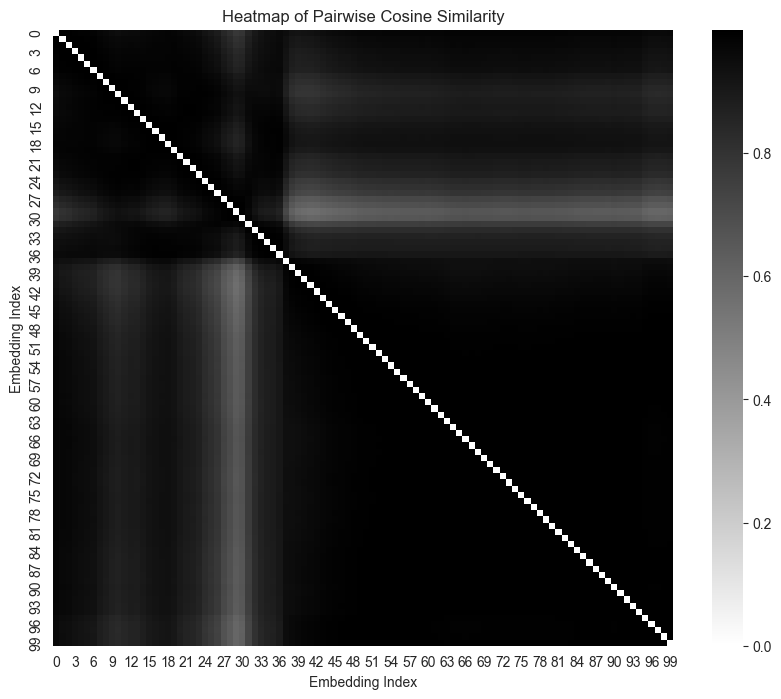

In [128]:
similarity_matrix_4, similar_pairs_4 = calculate_embeddings_similarity(ts_embedding_4)
plot_similarity_heatmap(similarity_matrix_4)

In [129]:
sorted_matrix_4, sorted_pairs_4 = sort_similarity_matrix(similarity_matrix_4)

Pairwise cosine similarity (sorted):
 [[0.99999928 0.99999928 0.99999915 ... 0.99998535 0.9999853  0.9999853 ]
 [0.99998509 0.99998509 0.99998495 ... 0.99996679 0.99996672 0.99996672]
 [0.99996644 0.99996644 0.9999662  ... 0.99993935 0.99993895 0.99993895]
 ...
 [0.66181422 0.66181422 0.66174954 ... 0.64299172 0.64267281 0.64267281]
 [0.64261488 0.64261488 0.64230651 ... 0.57268993 0.56997073 0.56997073]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(93, 94, 0.9999992823835333), (78, 80, 0.9999991531240313), (77, 78, 0.9999990963535987), (75, 76, 0.9999989694612929), (72, 73, 0.9999987516168531), (92, 93, 0.9999987071831098), (88, 89, 0.999998600935501), (78, 79, 0.999998506967561), (77, 79, 0.9999983225829382), (79, 80, 0.999997705404085), (74, 78, 0.9999975866072982), (81, 82, 0.9999973914064131), (77, 80, 0.9999972837261294), (67, 68, 0.9999970752435149), (69, 70, 0.999997055275911), (74, 77, 0.9999969816775369), (87, 88, 0.999996796260634

#### Example 5: Segment 5 from Amazon data

In [130]:
data_5 = normalize_data(segment_5,'Close')
ts_embedding_5 = create_and_train_ts_embedding (data_5)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2825Epoch 1, Loss: 0.2605842649936676
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2737
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1338Epoch 2, Loss: 0.11895065009593964
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1278
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0388Epoch 3, Loss: 0.027973027899861336
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0345
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0215Epoch 4, Loss: 0.0269619133323431
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0226
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0306Epoch 5, Loss: 0.025013167411088943
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0284
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0099Epoch 6, Loss: 0.008490504696965218
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0094
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0103Epoch 7, Loss: 0.010176870040595531
4/4 ━

In [131]:
embeddings_5 = print_ts_embeddings_info (ts_embedding_5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.00794378  0.03400084 -0.04287893  0.01345385  0.02151428 -0.04659158
   0.0331931  -0.00471908 -0.0205123   0.03974498  0.01944117 -0.00384333
   0.01417114  0.00169816 -0.00240665  0.02738922 -0.03577754  0.01420179
  -0.00944008  0.01041483  0.0006003   0.00834798  0.02492601  0.00335705
   0.02989266  0.01127864  0.03940301 -0.02840462  0.01389526 -0.03196478
  -0.02504634 -0.06183522 -0.01068224 -0.05609852  0.02529069 -0.01057624
  -0.03079162  0.02406884 -0.00262185 -0.01930376 -0.03744997  0.04270907
   0.03968572  0.03634262 -0.03492956 -0.02171464  0.02159367 -0.02246637
  -0.02356494  0.01463891]
 [-0.00912512  0.03092769 -0.04026646  0.01525797  0.02023643 -0.04183428
   0.02929848 -0.0024721  -0.01975829  0.03611814  0.02106917 -0.00609044
   0.01547641  0.00345115 -0.00530741  0.02541914 -0.03369432  0.01467003
  -0.0078745   0.00793066  0.00140808  0.00756191  0.02441654  0.00289

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Pairwise cosine similarity:
 [[0.         0.9977669  0.99787194 ... 0.91869432 0.91934388 0.92147929]
 [0.9977669  0.         0.9997398  ... 0.89277083 0.89346178 0.89594012]
 [0.99787194 0.9997398  0.         ... 0.89157807 0.89232225 0.89477919]
 ...
 [0.91869432 0.89277083 0.89157807 ... 0.         0.99999144 0.99995981]
 [0.91934388 0.89346178 0.89232225 ... 0.99999144 0.         0.99998024]
 [0.92147929 0.89594012 0.89477919 ... 0.99995981 0.99998024 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9977668988676536), (0, 2, 0.997871942088185), (0, 3, 0.994576695286454), (0, 4, 0.9736738217494082), (0, 5, 0.965865642873198), (0, 6, 0.9362132273160245), (0, 7, 0.9381757681509246), (0, 8, 0.9456670249240452), (0, 9, 0.9612061279976022), (0, 10, 0.9678623519375664), (0, 11, 0.9765653072656296), (0, 12, 0.9797735290287549), (0, 13, 0.9832383594094748), (0, 14, 0.9803539328337062), (0, 15, 0.9832765723608229), (0, 16, 0.9796073224132528), (0

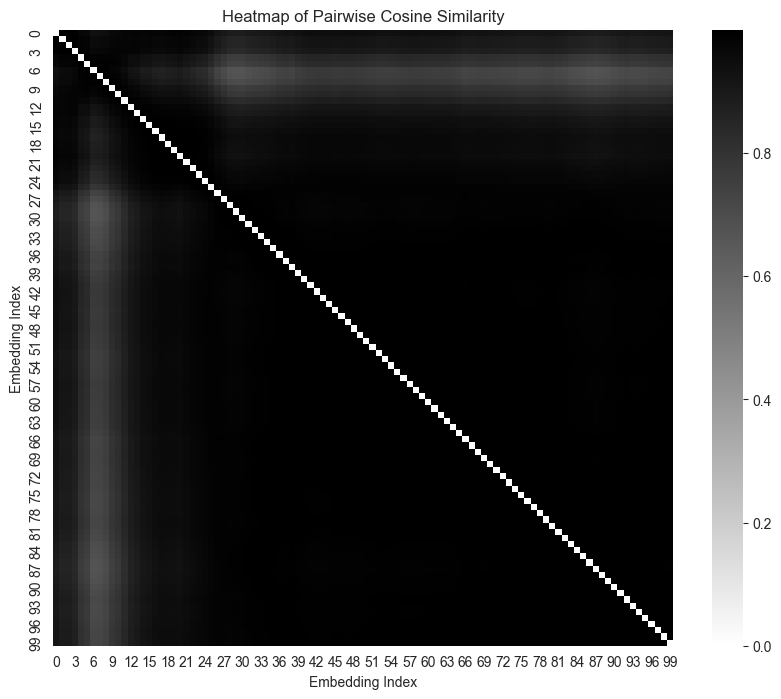

In [132]:
similarity_matrix_5, similar_pairs_5 = calculate_embeddings_similarity(ts_embedding_5)
plot_similarity_heatmap(similarity_matrix_5)

In [133]:
sorted_matrix_5, sorted_pairs_5 = sort_similarity_matrix(similarity_matrix_5)

Pairwise cosine similarity (sorted):
 [[0.9999983  0.9999983  0.99999729 ... 0.99996821 0.99996588 0.99996588]
 [0.99996573 0.99996573 0.99996531 ... 0.99993795 0.99993764 0.99993764]
 [0.99993746 0.99993746 0.99993706 ... 0.9999019  0.99990163 0.99990163]
 ...
 [0.73528708 0.73528708 0.73485318 ... 0.71630084 0.71580706 0.71580706]
 [0.71494556 0.71494556 0.71475785 ... 0.66924892 0.66851888 0.66851888]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(61, 63, 0.9999983008407753), (62, 63, 0.9999972920240288), (60, 62, 0.9999971541670288), (61, 62, 0.9999971155383782), (46, 47, 0.9999970755543252), (76, 77, 0.9999963132225799), (75, 76, 0.9999940785136006), (60, 61, 0.999994027234861), (71, 72, 0.9999934220325881), (72, 73, 0.9999927192449549), (93, 94, 0.9999926224294637), (68, 69, 0.9999924912755694), (57, 58, 0.9999924387810211), (69, 70, 0.9999919973889965), (97, 98, 0.9999914419723733), (47, 48, 0.9999914242207563), (94, 95, 0.999991321357

#### Example 6: Segment 6 from Amazon data

In [134]:
data_6 = normalize_data(segment_6,'Close')
ts_embedding_6 = create_and_train_ts_embedding (data_6)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2036Epoch 1, Loss: 0.19011946022510529
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1982
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0966Epoch 2, Loss: 0.08834856003522873
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0933
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0260Epoch 3, Loss: 0.02514922432601452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0257
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0166Epoch 4, Loss: 0.021039551123976707
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0184
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0253Epoch 5, Loss: 0.025761594995856285
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0255
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0158Epoch 6, Loss: 0.013600034639239311
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0149
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0107Epoch 7, Loss: 0.013501976616680622
4/4

In [135]:
embeddings_6 = print_ts_embeddings_info (ts_embedding_6)
print(embeddings_6.size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.07199686  0.02780066 -0.02223019  0.06363328 -0.07011896 -0.01864822
  -0.07081535  0.01451944 -0.03780987  0.09196675  0.05623463 -0.02531191
   0.02387146  0.0203354   0.07431028  0.0659373  -0.03621762  0.04852315
   0.0283732   0.06078333 -0.05894553  0.01771231  0.04229377  0.08704032
   0.05711064 -0.10034665 -0.19871771  0.0451614   0.01932044  0.02402441
  -0.00082045 -0.04392803  0.01725628 -0.07223893 -0.08622794  0.0657672
   0.04527563  0.02281012  0.01050588 -0.12733528 -0.09095991  0.02023662
   0.00567585  0.06101156  0.04102837  0.10022857  0.12029419  0.02735684
  -0.03966264 -0.06431832]
 [ 0.06879342  0.02597167 -0.02197194  0.05815908 -0.06683104 -0.01560963
  -0.06730635  0.01495915 -0.03654899  0.08759484  0.05175278 -0.02320295
   0.02368095  0.01898478  0.06969516  0.0615124  -0.03533454  0.04608972
   0.02695342  0.05849003 -0.05482904  0.01776218  0.04042453  0.081533

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Pairwise cosine similarity:
 [[0.         0.99987858 0.99952478 ... 0.98175632 0.98214033 0.98305333]
 [0.99987858 0.         0.99982144 ... 0.98112388 0.98153525 0.98248785]
 [0.99952478 0.99982144 0.         ... 0.9830556  0.983422   0.98429974]
 ...
 [0.98175632 0.98112388 0.9830556  ... 0.         0.99997112 0.99986951]
 [0.98214033 0.98153525 0.983422   ... 0.99997112 0.         0.99996054]
 [0.98305333 0.98248785 0.98429974 ... 0.99986951 0.99996054 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9998785789974469), (0, 2, 0.9995247755644828), (0, 3, 0.9988547711631046), (0, 4, 0.9976523025270146), (0, 5, 0.9972276547883394), (0, 6, 0.9963406783484707), (0, 7, 0.9942557060167325), (0, 8, 0.992350219376624), (0, 9, 0.9919979056725998), (0, 10, 0.9876681567860084), (0, 11, 0.9815801659314252), (0, 12, 0.9742197161346746), (0, 13, 0.9647029574887251), (0, 14, 0.9493082808969042), (0, 15, 0.9341798914465645), (0, 16, 0.9267850264369947), 

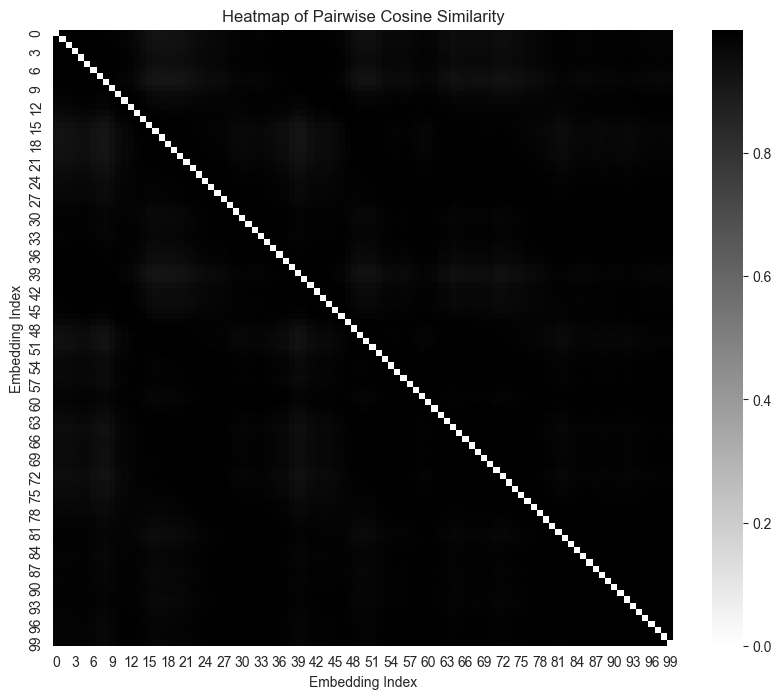

In [136]:
similarity_matrix_6, similar_pairs_6 = calculate_embeddings_similarity(ts_embedding_6)
plot_similarity_heatmap(similarity_matrix_6)

In [137]:
sorted_matrix_6, sorted_pairs_6 = sort_similarity_matrix(similarity_matrix_6)

Pairwise cosine similarity (sorted):
 [[0.99998653 0.99998653 0.99998177 ... 0.99984831 0.99984528 0.99984528]
 [0.99984215 0.99984215 0.99984211 ... 0.99969354 0.99968674 0.99968674]
 [0.99968571 0.99968571 0.99968566 ... 0.99952495 0.99952478 0.99952478]
 ...
 [0.93956697 0.93956697 0.939563   ... 0.93257673 0.93238353 0.93238353]
 [0.93233595 0.93233595 0.93215713 ... 0.91526786 0.91514477 0.91514477]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(90, 91, 0.9999865331438331), (67, 68, 0.99998177285443), (95, 96, 0.9999794746815683), (66, 67, 0.9999786970090181), (69, 70, 0.9999758032813315), (68, 69, 0.9999742049203816), (97, 98, 0.9999711230581452), (85, 86, 0.9999661989381909), (98, 99, 0.9999605371260591), (54, 55, 0.999958774994365), (32, 33, 0.9999535199225928), (25, 26, 0.9999463342285154), (91, 93, 0.9999415564937183), (96, 97, 0.9999402566146772), (96, 98, 0.9999388815949045), (67, 69, 0.9999350848356714), (55, 57, 0.99992821529706

Based on above presented heatmaps we can conclude that all of them have a white diagonal that represents zeros for the same valued pairs. Out of the six examples [Example 1: Segment 1 from Amazon data](#example-1-segment-1-from-amazon-data) and [Example 3: Segment 3 from Amazon data](#example-3-segment-3-from-amazon-data) are the most similar by their embeddings. If we compare their time series graphs we can also see that the graphs are quite similar, both of them contain increasing values. 